In [ ]:
# Dans ce notebook, on va essayer les codes de la démo sur des fichiers un par un
# afin de comprendre comment ça fonctionne et savoir si il y a besoin de faire des opéarations sur 
# les fichiers CSV.


In [2]:
# Import libraries
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os

In [3]:
# On va s'entrainer avec les données de Mars 
cat_directory = './data/mars/training/catalogs/'
cat_file = cat_directory + 'Mars_InSight_training_catalog_final.csv'
cat = pd.read_csv(cat_file)
cat

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),evid
0,XB.ELYSE.02.BHV.2022-02-03HR08_evid0005.csv,2022-02-03T08:08:27.000000,507.0,evid0005
1,XB.ELYSE.02.BHV.2022-01-02HR04_evid0006.csv,2022-01-02T04:35:30.000000,2130.0,evid0006


In [4]:
row = cat.iloc[0]
arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'],'%Y-%m-%dT%H:%M:%S.%f')
print(arrival_time)
# If we want the value of relative time, we don't need to use datetime
arrival_time_rel = row['time_rel(sec)']
print(arrival_time_rel)
# Let's also get the name of the file
test_filename = row.filename
print(test_filename)

2022-02-03 08:08:27
507.0
XB.ELYSE.02.BHV.2022-02-03HR08_evid0005.csv


In [5]:
# Maintenant on doit trouver le fichier csv correspondant à cette ligne dans le catalogue
data_directory = './data/mars/training/data/'
csv_file = f'{data_directory}{test_filename}'
data_cat = pd.read_csv(csv_file)
data_cat

,time(%Y-%m-%dT%H:%M:%S.%f),rel_time(sec),velocity(c/s)
0,2022-02-03T08:00:00.009000,0.00,0.000000
1,2022-02-03T08:00:00.059000,0.05,0.000128
2,2022-02-03T08:00:00.109000,0.10,0.000703
3,2022-02-03T08:00:00.159000,0.15,-0.001124
4,2022-02-03T08:00:00.209000,0.20,-0.003985
...,...,...,...
71995,2022-02-03T08:59:59.759000,3599.75,-0.003213
71996,2022-02-03T08:59:59.809000,3599.80,-0.003827
71997,2022-02-03T08:59:59.859000,3599.85,-0.002980
71998,2022-02-03T08:59:59.909000,3599.90,-0.000506


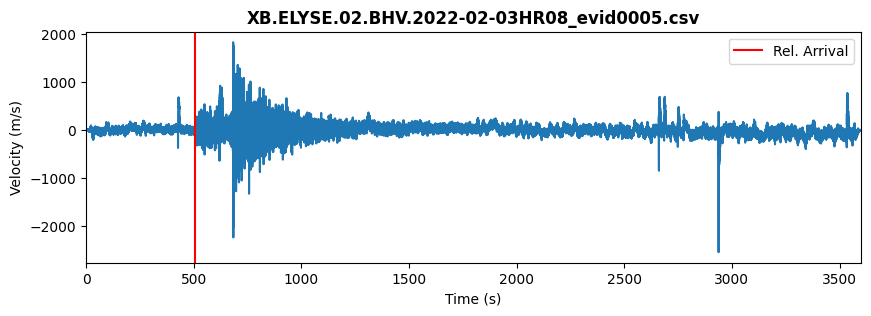

In [6]:
# Et maintenant, il faut afficher la courbe correspondante
# On choisit la méthode qu'on veut csv, mmm...
# Ici on choisit d'utiliser le fichier csv même si avec l'autre méthode c'est censé être plus rapide.
csv_times = np.array(data_cat['rel_time(sec)'].tolist())
csv_data = np.array(data_cat['velocity(c/s)'].tolist())

# Plot the trace! 
fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(csv_times,csv_data)

# Make the plot pretty
ax.set_xlim([min(csv_times),max(csv_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')

# Plot where the arrival time is
arrival_line = ax.axvline(x=arrival_time_rel, c='red', label='Rel. Arrival')
ax.legend(handles=[arrival_line])


Text(0.5, 1.0, 'XB.ELYSE.02.BHV.2022-02-03HR08_evid0005.csv')

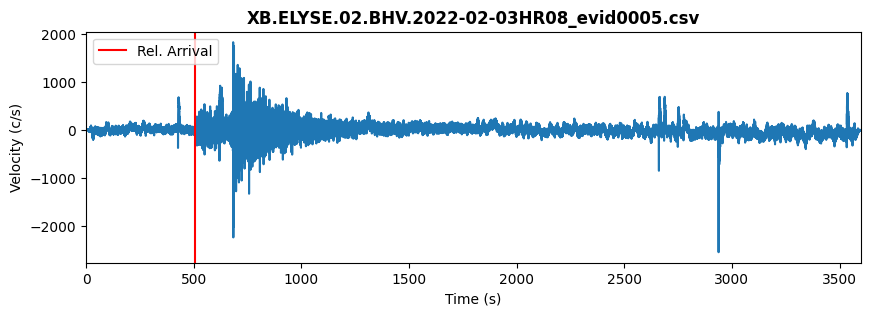

In [7]:
# On peut faire la même chose avec le miniseed file
data_directory = './data/mars/training/data/'

# On enlève le .csv de test_filename
filename = "XB.ELYSE.02.BHV.2022-02-03HR08_evid0005"


mseed_file = f'{data_directory}{filename}.mseed'
st = read(mseed_file)
# This is how you get the data and the time, which is in seconds
tr = st.traces[0].copy()
tr_times = tr.times()
tr_data = tr.data

# Start time of trace (another way to get the relative arrival time using datetime)
starttime = tr.stats.starttime.datetime
arrival = (arrival_time - starttime).total_seconds()

# Initialize figure
fig,ax = plt.subplots(1,1,figsize=(10,3))

# Plot trace
ax.plot(tr_times,tr_data)

# Mark detection
ax.axvline(x = arrival, color='red',label='Rel. Arrival')
ax.legend(loc='upper left')

# Make the plot pretty
ax.set_xlim([min(tr_times),max(tr_times)])
ax.set_ylabel('Velocity (c/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')



In [12]:
# On filtre le signal :

# Set the minimum frequency
minfreq = 3
maxfreq = 3,1

# Going to create a separate trace for the filter data
st_filt = st.copy()
st_filt.filter('bandpass',freqmin=minfreq,freqmax=maxfreq)
tr_filt = st_filt.traces[0].copy()
tr_times_filt = tr_filt.times()
tr_data_filt = tr_filt.data

from scipy import signal
from matplotlib import cm
f, t, sxx = signal.spectrogram(tr_data_filt, tr_filt.stats.sampling_rate)

# Plot the time series and spectrogram
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 1, 1)
# Plot trace
ax.plot(tr_times_filt,tr_data_filt)

# Mark detection
ax.axvline(x = arrival, color='red',label='Detection')
ax.legend(loc='upper left')

# Make the plot pretty
ax.set_xlim([min(tr_times_filt),max(tr_times_filt)])
ax.set_ylabel('Velocity (c/s)')
ax.set_xlabel('Time (s)')

ax2 = plt.subplot(2, 1, 2)
vals = ax2.pcolormesh(t, f, sxx, cmap=cm.jet, vmax=5e-17)
ax2.set_xlim([min(tr_times_filt),max(tr_times_filt)])
ax2.set_xlabel(f'Time (Day Hour:Minute)', fontweight='bold')
ax2.set_ylabel('Frequency (Hz)', fontweight='bold')
ax2.axvline(x=arrival, c='red')
cbar = plt.colorbar(vals, orientation='horizontal')
cbar.set_label('Power ((m/s)^2/sqrt(Hz))', fontweight='bold')

# ON VERRA PLUS TARD POUR LE CHOIX DES FREQUENCES A FILTRER

TypeError: unsupported operand type(s) for /: 'tuple' and 'float'

Text(0, 0.5, 'Characteristic function')

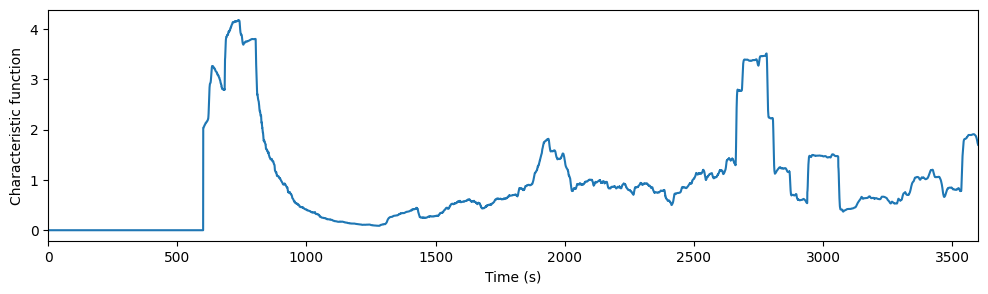

In [15]:
# Dernier étape, on applique l'algorithme STA/LTA afin de détecter si il y a seisme et si oui quand.

# Rappel : A STA/LTA algorithm moves two time windows of two lengths (one short, one long) across the seismic data. 
# The algorithm calculates the average amplitude in both windows, and calculates the ratio between them. If the data 
# contains an earthquake, then the short-term window containing the earthquake will be much larger than the long-term window -- resulting in a detection. 

from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset

# Sampling frequency of our trace
df = tr.stats.sampling_rate

# How long should the short-term and long-term window be, in seconds?
sta_len = 120
lta_len = 600

# Run Obspy's STA/LTA to obtain a characteristic function
# This function basically calculates the ratio of amplitude between the short-term 
# and long-term windows, moving consecutively in time across the data
cft = classic_sta_lta(tr_data, int(sta_len * df), int(lta_len * df))

# Plot characteristic function
fig,ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(tr_times,cft)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Characteristic function')

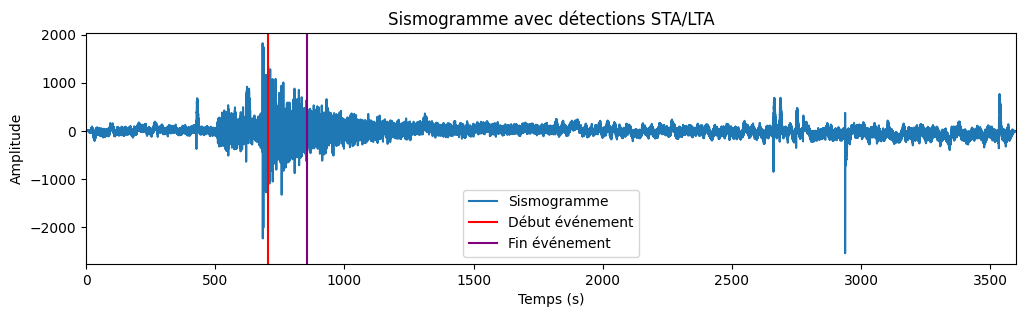

In [16]:
# Définition des seuils de déclenchement
thr_on = 4
thr_off = 1.5
on_off = np.array(trigger_onset(cft, thr_on, thr_off))

# Création du graphique
fig, ax = plt.subplots(1, 1, figsize=(12, 3))

# Tracé du sismogramme
ax.plot(tr_times, tr_data, label='Sismogramme')

# Tracé des déclencheurs
on_label_used = False
off_label_used = False
for i in range(len(on_off)):
    triggers = on_off[i]
    
    # Déclencheur "on" (début de l'événement)
    on_label = 'Début événement' if not on_label_used else ''
    ax.axvline(x=tr_times[triggers[0]], color='red', label=on_label)
    on_label_used = True
    
    # Déclencheur "off" (fin de l'événement)
    off_label = 'Fin événement' if not off_label_used else ''
    ax.axvline(x=tr_times[triggers[1]], color='purple', label=off_label)
    off_label_used = True

ax.set_xlim([min(tr_times), max(tr_times)])
ax.set_xlabel('Temps (s)')
ax.set_ylabel('Amplitude')
ax.legend()
plt.title('Sismogramme avec détections STA/LTA')
plt.show()

In [18]:
# Création d'un fichier Pandas 'dataframe' pour synthétiser les données

# File name and start time of trace
fname = row.filename
starttime = tr.stats.starttime.datetime

# Iterate through detection times and compile them
detection_times = []
fnames = []
for i in np.arange(0,len(on_off)):
    triggers = on_off[i]
    on_time = starttime + timedelta(seconds = tr_times[triggers[0]])
    on_time_str = datetime.strftime(on_time,'%Y-%m-%dT%H:%M:%S.%f')
    detection_times.append(on_time_str)
    fnames.append(fname)
    
# Compile dataframe of detections
detect_df = pd.DataFrame(data = {'filename':fnames, 'time_abs(%Y-%m-%dT%H:%M:%S.%f)':detection_times, 'time_rel(sec)':tr_times[triggers[0]]})
detect_df.head()

# Ce dataframe est à améliorer.

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec)
0,XB.ELYSE.02.BHV.2022-02-03HR08_evid0005.csv,2022-02-03T08:11:44.659000,704.65


In [19]:
# Création d'un fichier Pandas 'dataframe' pour synthétiser les données
fname = row.filename
starttime = tr.stats.starttime.datetime

# Listes pour stocker les données
detection_times_start = []
detection_times_end = []
fnames = []
durations = []
max_amplitudes = []
snr_values = []

for i in range(len(on_off)):
    triggers = on_off[i]
    
    # Temps de début et de fin
    start_time = starttime + timedelta(seconds=tr_times[triggers[0]])
    end_time = starttime + timedelta(seconds=tr_times[triggers[1]])
    
    # Durée de l'événement
    duration = (end_time - start_time).total_seconds()
    
    # Segment de données pour cet événement
    event_data = tr_data[triggers[0]:triggers[1]]
    
    # Amplitude maximale
    max_amp = np.max(np.abs(event_data))
    
    # Calcul du SNR (Signal-to-Noise Ratio)
    noise_window = tr_data[max(0, triggers[0]-1000):triggers[0]]  # 1000 échantillons avant l'événement
    signal_rms = np.sqrt(np.mean(event_data**2))
    noise_rms = np.sqrt(np.mean(noise_window**2))
    snr = 20 * np.log10(signal_rms / noise_rms) if noise_rms != 0 else float('inf')
    
    # Ajout des données aux listes
    detection_times_start.append(start_time.strftime('%Y-%m-%dT%H:%M:%S.%f'))
    detection_times_end.append(end_time.strftime('%Y-%m-%dT%H:%M:%S.%f'))
    fnames.append(fname)
    durations.append(duration)
    max_amplitudes.append(max_amp)
    snr_values.append(snr)

# Création du DataFrame amélioré
detect_df = pd.DataFrame({
    'filename': fnames,
    'start_time': detection_times_start,
    'end_time': detection_times_end,
    'duration_sec': durations,
    'max_amplitude': max_amplitudes,
    'SNR_dB': snr_values,
    'start_time_rel_sec': [tr_times[t[0]] for t in on_off],
    'end_time_rel_sec': [tr_times[t[1]] for t in on_off]
})

# Tri du DataFrame par temps de début
detect_df = detect_df.sort_values('start_time')

# Affichage des résultats
print(detect_df.to_string(index=False))

# Statistiques de base
print("\nStatistiques des détections:")
print(f"Nombre total de détections: {len(detect_df)}")
print(f"Durée moyenne des événements: {detect_df['duration_sec'].mean():.2f} secondes")
print(f"SNR moyen: {detect_df['SNR_dB'].mean():.2f} dB")

# Sauvegarde du DataFrame en CSV
output_file = 'Entrainement_summary.csv'
detect_df.to_csv(output_file, index=False)
print(f"\nRésultats sauvegardés dans {output_file}")

                                   filename                 start_time                   end_time  duration_sec  max_amplitude    SNR_dB  start_time_rel_sec  end_time_rel_sec
XB.ELYSE.02.BHV.2022-02-03HR08_evid0005.csv 2022-02-03T08:11:44.659000 2022-02-03T08:14:14.209000        149.55    1325.717529 -3.145273              704.65             854.2

Statistiques des détections:
Nombre total de détections: 1
Durée moyenne des événements: 149.55 secondes
SNR moyen: -3.15 dB

Résultats sauvegardés dans Entrainement_summary.csv


In [21]:
# Création d'un fichier Pandas 'dataframe' pour synthétiser les données
fname = row.filename
starttime = tr.stats.starttime.datetime

# Listes pour stocker les données
detection_times_start = []
detection_times_end = []
fnames = []
durations = []
max_amplitudes = []
snr_values = []

for i in range(len(on_off)):
    triggers = on_off[i]
    
    # Temps de début et de fin
    start_time = starttime + timedelta(seconds=tr_times[triggers[0]])
    end_time = starttime + timedelta(seconds=tr_times[triggers[1]])
    
    # Durée de l'événement
    duration = (end_time - start_time).total_seconds()
    
    # Segment de données pour cet événement
    event_data = tr_data[triggers[0]:triggers[1]]
    
    # Amplitude maximale
    max_amp = np.max(np.abs(event_data))
    
    # Calcul du SNR (Signal-to-Noise Ratio)
    noise_window = tr_data[max(0, triggers[0]-1000):triggers[0]]  # 1000 échantillons avant l'événement
    signal_rms = np.sqrt(np.mean(event_data**2))
    noise_rms = np.sqrt(np.mean(noise_window**2))
    snr = 20 * np.log10(signal_rms / noise_rms) if noise_rms != 0 else float('inf')
    
    # Ajout des données aux listes
    detection_times_start.append(start_time.strftime('%Y-%m-%dT%H:%M:%S.%f'))
    detection_times_end.append(end_time.strftime('%Y-%m-%dT%H:%M:%S.%f'))
    fnames.append(fname)
    durations.append(duration)
    max_amplitudes.append(max_amp)
    snr_values.append(snr)

# Création du DataFrame amélioré
detect_df = pd.DataFrame({
    'filename': fnames,
    'start_time': detection_times_start,
    'end_time': detection_times_end,
    'duration_sec': durations,
    'max_amplitude': max_amplitudes,
    'SNR_dB': snr_values,
    'start_time_rel_sec': [tr_times[t[0]] for t in on_off],
    'end_time_rel_sec': [tr_times[t[1]] for t in on_off]
})

# Tri du DataFrame par temps de début
detect_df = detect_df.sort_values('start_time')

# Affichage des résultats
print(detect_df.to_string(index=False))

# Statistiques de base
print("\nStatistiques des détections:")
print(f"Nombre total de détections: {len(detect_df)}")
print(f"Durée moyenne des événements: {detect_df['duration_sec'].mean():.2f} secondes")
print(f"SNR moyen: {detect_df['SNR_dB'].mean():.2f} dB")

# Création du nom de fichier de sortie
output_filename = os.path.splitext(os.path.basename(fname))[0] + "_summary.csv"

# Sauvegarde du DataFrame en CSV
detect_df.to_csv(output_filename, index=False)
print(f"\nRésultats sauvegardés dans {output_filename}")

                                   filename                 start_time                   end_time  duration_sec  max_amplitude    SNR_dB  start_time_rel_sec  end_time_rel_sec
XB.ELYSE.02.BHV.2022-02-03HR08_evid0005.csv 2022-02-03T08:11:44.659000 2022-02-03T08:14:14.209000        149.55    1325.717529 -3.145273              704.65             854.2

Statistiques des détections:
Nombre total de détections: 1
Durée moyenne des événements: 149.55 secondes
SNR moyen: -3.15 dB

Résultats sauvegardés dans XB.ELYSE.02.BHV.2022-02-03HR08_evid0005_summary.csv
